# classification with xgboost
model v3
- preliminary model
- data with all 1352 important features based on pca and threshold
- imbalanced classification still not dealt with

In [1]:
# ignore warnings
import warnings
warnings.filterwarnings("ignore")

# data
import pandas as pd
import ast

# visualization
import matplotlib.pyplot as plt

# chosen models
from xgboost import XGBClassifier

# feature engineering
from xgboost import plot_importance

# model training selection
from sklearn.model_selection import train_test_split

## model evaluation metrics
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import log_loss
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import cohen_kappa_score

In [2]:
df = pd.read_csv('../data/combined_feng.csv', index_col=0)
df.shape

(3000, 7353)

In [3]:
df.head(3)

,Number of Founders,Number of Funding Rounds,Trend Score (7 Days),Trend Score (30 Days),Trend Score (90 Days),Early Stage Venture,M&A,Seed,Made Acquisitions,Made Acquisitions; Was Acquired,...,last_funding_amount,cvr,last_funding_amount_usd,last_equity_funding_amount,last_equity_funding_amount_usd,total_equity_funding_amount,total_equity_funding_amount_usd,total_funding_amount,total_funding_amount_usd,female_led
Organization Name,,,,,,,,,,,,,,,,,,,,,
CMC,1,1,-0.4,-0.8,-1.2,1.0,0.0,0.0,0.0,0.0,...,10000000000,0.16,1.600000e+09,10000000000,1.600000e+09,10000000000,1.600000e+09,10000000000,1.600000e+09,0
Ping An Healthcare Management,1,1,-0.1,-0.2,-0.4,1.0,0.0,0.0,0.0,0.0,...,1150000000,1.00,1.150000e+09,1150000000,1.150000e+09,1150000000,1.150000e+09,1150000000,1.150000e+09,0
LeSee,1,1,-0.4,0.0,-0.5,1.0,0.0,0.0,0.0,0.0,...,1080000000,1.00,1.080000e+09,1080000000,1.080000e+09,1080000000,1.080000e+09,1080000000,1.080000e+09,0


### get all top features based on pca

In [4]:
with open('high_var_org_col_index.txt', 'r') as reader:
    high_var_org_col_index = reader.read()

In [5]:
high_var_org_col_index = ast.literal_eval(high_var_org_col_index)

In [6]:
df1352 = df[df.columns[high_var_org_col_index]]

### split data

In [7]:
# get data
X = df1352
y = df['female_led']

In [8]:
# split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

## model evaluation

In [9]:
def metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred) #perfect=1
    precision = precision_score(y_true, y_pred) #perfect=1
    recall = recall_score(y_true, y_pred) #perfect=1
    f1 = f1_score(y_true, y_pred) #perfect=1
#     roc_auc = roc_auc_score(y, clf.decision_function(X)) #perfect=1
#     log = log_loss(y_true, y_pred) #perfect=0
    mcc = matthews_corrcoef(y_true, y_pred) #perfect=1
    kappa = cohen_kappa_score(y_true, y_pred) #perfect=1
    
#     print(f'accuracy={accuracy},\
#             precision={precision}, recall={recall}, \
#             f1={f1}, mcc={mcc}, kappa={kappa}')

    return [accuracy, precision, recall, f1, mcc, kappa]

In [10]:
def evaluate(model, X_train=X_train, X_test=X_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return metrics(y_test, y_pred)

## machine learning

In [11]:
xgb = XGBClassifier()

In [12]:
metrics_xgb = evaluate(xgb)
metrics_xgb

[19:45:21] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[0.9575757575757575,
 0.14285714285714285,
 0.02702702702702703,
 0.045454545454545456,
 0.0469293226254877,
 0.033966823103015686]

Result is high in accuracy but precision and recall rate is even lower than before because the classification label is extremely imbalanced: the negative class takes up 95% of the dataset. Dealing with imbalanced class is necessary.

In [13]:
important_features_dict = xgb.get_booster().get_score(importance_type='weight')
important_cols = list(important_features_dict.keys())

In [14]:
len(important_cols)

48

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

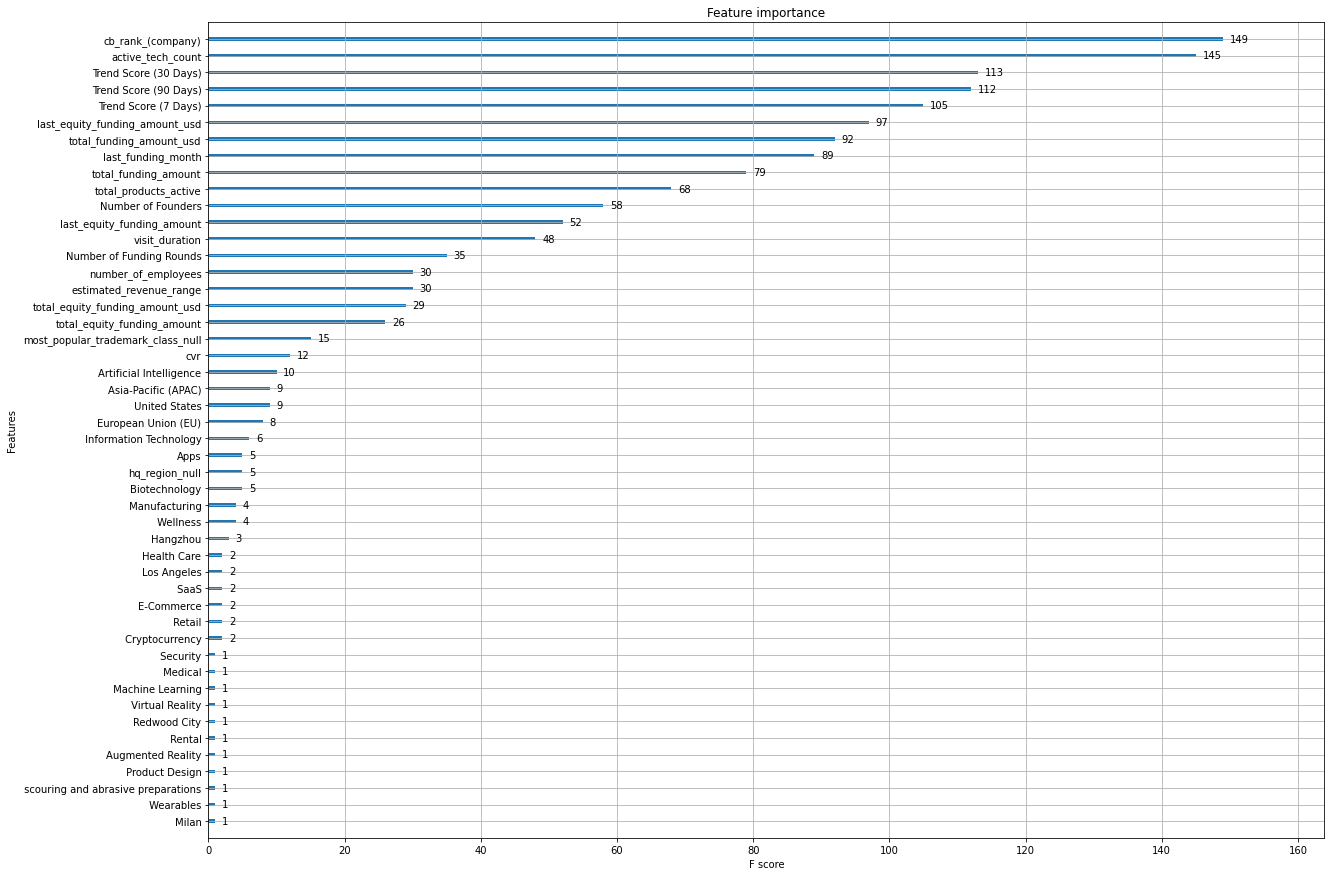

In [15]:
plt.rcParams["figure.figsize"] = (20, 15)
plot_importance(xgb, max_num_features=50)

### Feature Selection
Somehow the selected PCA columns also resulted in a very different feature selection in the xgboost model compared to the first time. 
- v1: xgboost selected 92 out of 7532
- v2: xgboost selected 6 out of 100
- v3: xgboost selected 48 out of 1352

all these information is before dealing with imbalance of the dataset

### Version Differences

model_version | feature selection | imbalanced class | hyperparameter tuning | cross validation
--------------|-------------------|------------------|-----------------------|-----------------
xgboost_v1 | no | no | no | no
xgboost_v2 | yes, top100 | no | no | no
xgboost_v3 | yes, top all 1352 | no | no | no

### Model Results

model_version | settings | accuracy | precision | recall | f1 | mcc | kappa
--------------|----------|----------|-----------|--------|----|-----|------
xgboost_v1 | n/a | 0.9575757575757575 | 0.14285714285714285 | 0.02702702702702703 | 0.045454545454545456 | 0.0469293226254877 | 0.033966823103015686
xgboost_v2 | top100 features | 0.9565656565656566 | 0.0 | 0.0 | 0.0 | -0.015386239477696191 | -0.01053980914399677
xgboost_v3 | top1352 features | 0.9575757575757575 | 0.14285714285714285 | 0.02702702702702703 | 0.045454545454545456 | 0.0469293226254877 | 0.033966823103015686